In [81]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from hdf5manager import hdf5manager as h5
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import scipy
from skimage.measure import label, regionprops
from scipy.ndimage.filters import gaussian_filter, convolve
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from opticFlow import opticFlow as of
import colorsys
import wholeBrain as wb
import cv2

In [82]:
path = '/Users/shreyamantripragada/Documents/test_angs_mags.hdf5'

h = h5(path) 
print(h.keys())
print(h.keys()[2])
print(dir(h))
mov = h.load('mags')
value = h.load('rot_angs')
# angs = h.load('rot_angs')
# start_stop = h.load('start_stop_index')

['start_stop_index', 'dfof', 'mags', 'rot_angs']
mags
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'close', 'keys', 'load', 'open', 'path', 'print', 'save', 'verbose']


In [83]:
#print(mov.shape)
#plt.plot(np.sum(~np.isnan(value), axis=(1,2)))
nan_lists = value[~np.isnan(value)]
print(nan_lists)
#print (findMeans(value))

[140.38737 144.20444 155.10669 ... 305.8011  310.7476  311.05035]


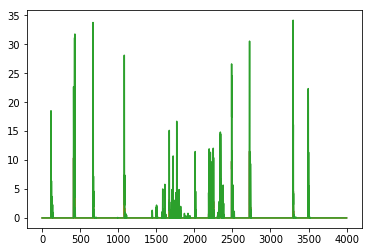

In [84]:
mean = np.mean(mov, axis = (1, 2))
standardDev = np.std(mov, axis = (1, 2))
average = np.average(mov, axis = (1, 2))
plt.plot(mean)
plt.plot(average)
plt.plot(standardDev)

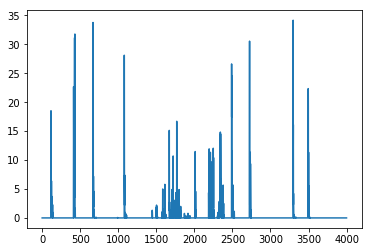

In [85]:
standardDev = np.std(mov, axis = (1, 2))
plt.plot(standardDev)

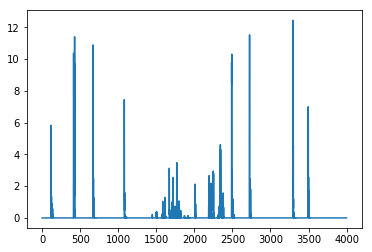

In [86]:
average = np.average(mov, axis = (1, 2))
plt.plot(average)

In [ ]:
wb.playMovie(mov)


Playing Movie
-----------------------
preprocessing data...
Pre-processing movie rescaling...

Rescaling Movie
-----------------------
mean: 0.09717086151820375 low: 3 high: 7 std: 2.3813770774755803
newMin: -7.046960370908537
newMax 16.766810403847266
amin 0.0
amax 407.083147251264
newSlope: 15.20861713456773


In [ ]:
fig,axs = plt.subplots(1, 2)
axs[0].imshow(mov[431], aspect = "auto", cmap = "magma")
axs[0].axis("on")
axs[1].imshow(mov[434], aspect = "auto", cmap = "nipy_spectral")
axs[1].axis("on")
#plt.colorbar()

In [ ]:
plt.imshow(mov[431], aspect = "auto", cmap = "magma")
plt.colorbar()

In [ ]:
def localMaxima2d(array_2d):
    # finds local maxima of a given 2d array
    neighborhood = np.ones((5,5))
    local_max = maximum_filter(array_2d, footprint=neighborhood)==array_2d
    background = (array_2d==0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    lmax = local_max ^ eroded_background
    return lmax

In [ ]:
for i, frame in enumerate(mov[430:432]):
    fmax = localMaxima2d(frame)
    #fmax1 = label(fmax)
    #fmax.axis("off")
    plt.imshow(fmax)

In [ ]:
#includes 0s with the means
def findMeans(array_3d):
    all_means = []
    x = []
    for i, frame in enumerate(array_3d):
        all_means.append(np.mean(frame))
        x.append(i)
    plt.scatter(x, all_means)
    return all_means

amount = findMeans(mov)
print (amount)

In [ ]:
#includes 0s with the standard deviation
def standardDeviation(array_3d):
    all_deviations = []
    x = []
    for i, frame in enumerate(array_3d):
        mean = np.mean(frame)
        x.append(i)
        deviation = 0
        deviations = []
        for r in frame:
            for c in range(len(r)):
                deviations.append((r[c] - mean) ** 2)
        mean1 = np.mean(deviations)
        current_deviation = mean1 ** (1/2)
        all_deviations.append(current_deviation)
    #plt.plot(x, all_deviations, "bo")
    return all_deviations

    
standardDev = standardDeviation(mov)
print (standardDev)

In [ ]:
# def return_dfof(amount):
#     return amount

# value_dfof = return_dfof(dfof)
# print(value_dfof)
# print(len(value_dfof))

In [ ]:
path2 = '/Users/shreyamantripragada/Documents/brain_data.hdf5'

k = h5(path2)
k.keys()
dfof = k.load('dfof_mean')
h.save({'dfof':dfof})

plt.plot(dfof)

In [ ]:
print (mov.shape)
mean = np.mean(mov, axis = (1, 2))
standardDev = np.std(mov, axis = (1, 2))
fig, axis = plt.subplots(3, figsize = (20, 15), sharex = True)


time = np.arange(dfof.shape[0])/10
time2 = np.arange(mean.shape[0])/30
time3 = np.arange(standardDev.shape[0])/30

#graphing the mean graph 
axis[0].plot(time2, mean, color = 'g')
axis[0].set_ylabel('Magnitude')
axis[0].set_title('Movement')

#graphing the dfof(brain activity) graph
axis[1].plot(time, dfof, color = 'b')
axis[1].set_ylabel('dfof')
axis[1].set_xlabel('time(s)')
axis[1].set_title('Brain activity')

#graphing the standard deviation graph
axis[2].plot(time3, standardDev, color = 'k')
axis[2].set_title('Magnitude')
axis[2].set_ylabel('Deviation')
axis[2].set_xlabel('Time')

In [ ]:
#prints out the dips of the graph, using derivatives 
#print (mov.shape)

def finding_derivative_points_brain_data(array_2d): 
    der = np.zeros_like(dfof)
    time = np.arange(der.shape[0])/10
    
    for i, j in enumerate(dfof):
        if i == 0 or i == dfof.shape[0]:
            continue
        else:
            der[i] = j - dfof[i-1]
        
    derivation_value = der/.1
    
    return derivation_value
        
value = finding_derivative_points(dfof)
print(value)

In [ ]:
#print (mov.shape)
print ("Displays the dips in the graph, using the derivative line")

fig, axis = plt.subplots(1, figsize = (20, 5))
time = np.arange(der.shape[0])/10

for i, j in enumerate(mov):
    if i == 0 or i == mov.shape[0][0]:
        continue
    else:
        der[i] = j - dfof[i-1]
der_values = der/.1
plt.plot(der_values)
print("derivation points: " + str(der_values))
plt.plot(dfof)
print("brain data points: " + str(dfof))
value = plt.xlim([0, 400])

In [ ]:
#print (mov.shape)
print ("Displays the dips in the graph, using derivatives")
print ("The graph is the original brain data and derivation line, but from [0, 150] and draws lines of either green(increasing) or red(decreasing)" + 
       "depending on the point of the graph. ")

der = np.zeros_like(dfof)*10
# Brain Activity Boundaries
for i, val in enumerate(dfof):
    if i == 0 or i == dfof.shape[0]:
        continue
    else:
        der[i] = val - dfof[i-1]
der *= 10

d_switch = []
u_switch = []

# Derivative of the graph by points
typ

u_switch = np.array(u_switch)/10
d_switch = np.array(d_switch)/10

time = np.arange(der.shape[0])/10

fig, axis = plt.subplots(1, figsize = (20, 5))
time = np.arange(der.shape[0])/10

for i, j in enumerate(dfof):
    if i == 0 or i == dfof.shape[0]:
        continue
    else:
        der[i] = j - dfof[i-1]
plt.plot(der/.1)
plt.xlim([0, 400])
plt.plot(dfof)

#plt.plot(time, der/.1, color = 'k')
for line in u_switch:
    go_up = plt.axvline(x = line, color='g')
for line in d_switch:
    go_down = plt.axvline(line, color='r')
plt.xlim([0,150])
plt.show()




In [ ]:
time[-1]

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame

In [ ]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)
df

In [ ]:
df.dtypes

In [ ]:
df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]), columns=['a', 'b', 'c'])
df2

In [ ]:
d = {'Mean': [1, 2], 'Range': [3, 4], 'Magnitude':[0, 0], 'DfΔf': [0, 0], 'Dipped Values': [0, 0]}
df = pd.DataFrame(data=d)
df

In [ ]:
# values = [ (0, 0, 0, 0, 0, 0, 0, 0, 0) ,
#              (0, 0, 0 , 0, 0, 0, 0, 0, 0) ,
#              (0, 0, 0 , 0, 0, 0, 0, 0, 0),
#              (0, 0, 0 , 0, 0, 0, 0, 0, 0),
#              (0, 0, 0 , 0, 0, 0, 0, 0, 0)]
 
#Create a DataFrame object
dfObj = pd.DataFrame()
dfObj1 = pd.DataFrame()
dfObj2 = pd.DataFrame()
dfObj3 = pd.DataFrame()
#print(len(standardDev))
#print(standardDev)
dfObj['mean_brain'] = amount
dfObj['std_brain'] = standardDev
#dfObj['df/f_brain'] = value_dfof
#pd.concat([dfObj, dfObj1, dfObj2], axis=1)

print(dfObj.loc[100:129,'mean_brain'])
print(dfObj1.loc[100:129, 'std_brain'])
#print(dfObj2.loc[100:129, 'df/f_brain'])

In [ ]:
der = np.zeros_like(dfof)*10
# Brain Activity Boundaries
for i, val in enumerate(dfof):
    if i == 0 or i == dfof.shape[0]:
        continue
    else:
        der[i] = val - dfof[i-1]
der *= 10

d_switch = []
u_switch = []
range_list = []
differnce = 0

# Derivative of the graph by points
for i, val in enumerate(der):
    if i == 0 or i == der.shape[0]:
        continue
    elif (val > 0) and (der[i-1] < 0):
        u_switch.append(i)
    elif (val < 0) and (der[i-1] > 0):
        d_switch.append(i)

u_switch = np.array(u_switch)/10
d_switch = np.array(d_switch)/10

time = np.arange(dfof.shape[0])/10
fig, axis = plt.subplots(1, figsize = (20, 5))



# Line-Scatter Graph
plt.scatter(time[der<0], der[der<0], linewidths =0.1)
plt.scatter(time[der>0], der[der>0])
plt.plot(time, dfof, color = 'k')
for line in u_switch:
    plt.axvline(x = line, color='g')
for line in d_switch:
    plt.axvline(line, color='r')
plt.xlim([0,50])
plt.show()


In [ ]:
# def calculating_range():
#     range_list = []
#     for value in range(len(u_switch)):
#         for amount in range(len(d_switch)): 
#             difference = d_switch[amount] - u_switch[value]
#             range_list.append(difference)
    
#     return range_list
        

# range_amt = calculating_range()



In [ ]:
# values = [ (0, 0, 0, 0, 0, 0, 0, 0, 0) ,
#              (0, 0, 0 , 0, 0, 0, 0, 0, 0) ,
#              (0, 0, 0 , 0, 0, 0, 0, 0, 0),
#              (0, 0, 0 , 0, 0, 0, 0, 0, 0),
#              (0, 0, 0 , 0, 0, 0, 0, 0, 0)]
 
#Create a DataFrame object
dfObj = pd.DataFrame()
dfObj1 = pd.DataFrame()
dfObj2 = pd.DataFrame()
dfObj3 = pd.DataFrame()
#print(len(standardDev))
#print(standardDev)
dfObj['mean_brain'] = amount
dfObj['std_brain'] = standardDev
# dfObj['df/f_brain'] = value_dfof
#dfObj['range_brain'] = range_final


print(dfObj.loc[100:129])
pd.concat([dfObj, dfObj1, dfObj2], axis=1)

print(dfObj.loc[100:129,'mean_brain'])
print(dfObj1.loc[100:129, 'std_brain'])
print(dfObj2.loc[100:129, 'df/f_brain'])

In [ ]:
def same_size(list_1, list_2):
    new_array = []
    if (len(list_1) > len(list_2)):
        divide = len(list_1) / len(list_2)
        
        if (divide > 2):
            for i in range(len(list_2)):
                new_array.append(list_1[i * int(np.floor(divide))])
                
        else: 
            new_array = list_1[0:len(list_2)]
            
    elif(len(list_2) > len(list_1)):
        divide = len(list_2) / len(list_1)
        
        if (divide > 2):
            for i in range(len(list_1)):
                new_array.append(list_2[i* int(np.floor(divide))])
                
        else: 
            new_array = list_2[0:len(list_1)]
            
    return new_array

shreya = [1, 2, 3, 4, 5]
emma = [1, 2, 3]
value = same_size(shreya, emma)
print(value)

# import numpy as np
# a = np.arange(10)
# b = np.zeros(a.shape[0]*3)

# b[::2] = a
# b[1::3] = a
# b[2::3] = a

# for i in np.arange(n): 
# b[i::n] = a

In [ ]:
# Average magnitude in multiple dimensions
def motionCharacterize(array3d):
    brain_magnitude = np.zeros(array3d.shape[0])
    for n, frame in enumerate(array3d):
        brain_magnitude[n] = np.mean(frame)

    win_size = 10
    mag_mean = np.convolve(brain_magnitude, np.ones(win_size)/win_size, mode = 'same')

    threshold = np.zeros(mag_mean.shape)
    threshold[mag_mean > 0] = 1 
    frame_ind = np.where(threshold == 1)

    start = []
    end = []
    for i, frame in enumerate(frame_ind[0]):
        if i == 0:
            start.append(frame)
        elif len(frame_ind[0])-1 == i:   
            end.append(frame)
        elif (frame + 1) != (frame_ind[0][i + 1]):
            end.append(frame)
            start.append(frame_ind[0][i + 1])
            
#     Duration of event frames in seconds
    event_frames = (np.array(end) - np.array(start))/30
    
    mag_per_event = np.zeros(array3d.shape[0])
    duration = np.zeros(array3d.shape[0])
    rest = np.zeros_like(duration)

    for i, st in enumerate(start):
        if i == 0:        
            rest[:st] = st
            rest[end[i]:start[i+1]] = start[i+1] - end[i]
        elif i == len(start)-1:
            rest[end[i]:] = rest.shape[0] - end[i]
        else:
            rest[end[i]:start[i+1]] = start[i+1] - end[i]
        mag_per_event[st:end[i]] = np.sum(array3d[st:end[i]])/event_frames[i]
        duration[st:end[i]] = event_frames[i]
        
# #     Duration intervals
#     frame_durations = []
#     for i in range(len(start)):
#         interval = end[i] - start[i]
#         frame_durations.append(interval)
#     print(frame_durations)
    
    #   Magnitude events
#     fig = plt.figure(figsize = (10,5))
#     plt.plot(brain_magnitude, color='k')
#     plt.plot(mag_mean,color='g')
#     plt.plot(threshold,color='r')
#     plt.ylim([0,2])
#     plt.show()
#     plt.plot(mag_per_event)
#     plt.show()

#     print(frame_durations[1])
#     for i in frame_durations:
#     print(dfDur)

    
    return mag_per_event, duration, rest
dfDur = pd.DataFrame()

dfDur['mag_per_event'], dfDur['duration'], dfDur['rest']= motionCharacterize(mov)
# mag_data = motionCharacterize(mov)
# plt.plot(dfDur['mag_per_event'])

fig = plt.figure(figsize=(10,5))
plt.plot(dfDur['duration'] * 100, label='duration')
plt.plot(dfDur['rest'], label='rest')
plt.legend()
plt.show()    

In [ ]:
df = pd.DataFrame()

means = findMeans(mov)
mode = common_occurences(mov)
m = []

for i in mov:
    m += mode.get(means[i])
    fx
            #df['frame_number_of_brain_data']
            # df["frame_number_of_brain_data": 0] = range(0, 4000)
            # df["move_mean_of_magnitude_of_brain_data" : 1] = findMeans(mov)
            # df["standard_deviation_of_brain_data":2] = standardDeviation(mov)

            range_value = np.max(mov) - np.min(mov)
            df['move_mean_of_brain_magnitude'] = np.mean(mov, axis = (1, 2))
            df['standard_deviation_of_brain_magnitude'] = np.std(mov, axis=(1, 2))
            df['max_value_of_brain_magnitude'] = np.max(mov, axis = (1, 2))
            df['mode_of_brain_magnitude'] = m
            #df['range_of_brain_magnitude'] = np.arange(mov, axis = (1, 2))
            #df['mode_of_brain_magnitude'] = sp.mode(mov, aixs = (1, 2))

In [ ]:
def findEvent(array_3d):
    means = findMeans(array3d)
    is_event = []
    for i in means:
        if i > 0:
            is_event.append("event")
        else:
            is_event.append("rest")
    return is_event

In [ ]:
def findRange(array_3d):
    return np.max(array3d, axis = (1,2))

In [ ]:
def finding_range_values(dfof): 
    #finding the ranges of snippet of the brain data
    der = np.zeros_like(dfof)*10
    # Brain Activity Boundaries
    for i, val in enumerate(dfof):
        if i == 0 or i == len(dfof) - 1:
            continue
        else:
            der[i] = val - dfof[i-1]
    der *= 10

    d_switch = [] #the decreasing part of the graph 
    u_switch = [] #the increasing part of the graph
    range_list = []

    # Derivative of the graph by points
    for i, val in enumerate(der):
        if i == 0 or i == len(der) - 1:
            continue
        elif (val > 0) and (der[i-1] < 0):
            u_switch.append(i)
        elif (val < 0) and (der[i-1] > 0):
            d_switch.append(i)

    u_switch = np.array(u_switch)/10
    d_switch = np.array(d_switch)/10

    return u_switch, d_switch

value = finding_range_values(dfof)
print(value)

In [ ]:
def range_of_sections(u_switch, d_switch):
    difference_list = []
    difference_val = 0
    
    for i in range(len(u_switch)): 
        for j in range(len(d_switch)):
            difference_val = abs(d_switch[j] - u_switch[i])
            difference_list.append(difference_val)
    
    return np.around(difference_list, 3)
    
final_range_list = range_of_sections(u_switch, d_switch)
print(final_range_list)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mov)


In [ ]:
def finding_range_values(array2d): 
    print("entered the finding_range_values function")
    #finding the ranges of snippet of the brain data
    d_switch = [] #the decreasing part of the graph 
    u_switch = [] #the increasing part of the graph
    
    for i in range(len(array2d) - 1):
        if i == 0 or i == len(array2d):
            continue
        elif array2d[i-1] < array2d[i] and array2d[i] > array2d[i+1]:
            u_switch.append(i)
        elif array2d[i-1] > array2d[i] and array2d[i] < array2d[i+1]:
            d_switch.append(i)
            
    return u_switch, d_switch, array2d

def range_of_sections(u_switch, d_switch, array2d):
    print("entered the range_of_sections function")
    #u_switch is the list of the indices of all the maxs
    #d_switch is the list of the indices of all the mins
    difference_list = []
    if (d_switch[0] > u_switch[0]):
        #starts on a min and goes up to the first max
        difference_list.append(array2d[u_switch[0]] - array2d[0])
    else:
        difference_list.append(array2d[0] - array2d[d_switch[0]])
    for i in range(len(u_switch)):
        if i == 0:
            continue
        difference_list.append(abs(abs(array2d[u_switch[i]] - array2d[d_switch[i]])))
    
    return difference_list

u, d, array = finding_range_values(dfof)
plt.plot(dfof)
for line in u:
    plt.axvline(x = line, color='g')
for line in d:
    plt.axvline(line, color='r')
plt.xlim([0,150])

print(range_of_sections(u, d, array))



In [ ]:
def list_of_total_magnitude(array3d):
    print("entered the list_of_total_magnitude function")
    total = []
    for i in array3d:
        total.append(np.sum(i))
    return total

In [ ]:
def total_magnitude(array2d):
    total = np.sum(array2d)
    
    return total
total_magnitude(dfof)

In [ ]:
def same_size_up(small, big):
    scalar = len(big)/len(small)
    scaled = []
    index = 0
    count = 0
    for i in range(len(big)):
        if count >= scalar:
            index += 1
            scaled.append(small[index])
            count = 1
        else:
            scaled.append(small[index])
            count += 1
    return scaled

In [ ]:
def surface_area(new_val):
    
    area_count = []
    for i in new_val:
        count = 0
        for r in i:
            if r > 0:
                count += 1
                    
        area_count.append(count)
        
    return area_count
    
surface_area(same_size_up(dfof, mov))

In [ ]:
print(np.around(dfof, 3))
print(np.around(mov, 3))

In [ ]:
# #print(dfof)
# def motion_percentage(array2d):
#     points = []
#     percent_list = []
#     #print("np.min: " + str(np.min(array2d)))
#     #print("array2d: " + str(array2d))
#     array2d -= np.min(array2d)
#     #print("array2d_new: " + str(array2d))
#     total = np.sum(array2d)
    
    
#     for i in array2d:
#         if len(points) < 10:
#             points.append(i)
#         elif len(points) == 10:
#             for i in np.arange(10):
#                 percent_list.append(np.sum(points))
#         else:
#             points = []
       
#     rounded_list = np.around(((percent_list/total) * 100), 3)
    
#     return rounded_list
# value = motion_percentage(mov)
# print(value)

In [ ]:
def find_means(array_3d):
    all_means = []
    x = []
    for i, frame in enumerate(array_3d):
        all_means.append(np.mean(frame))
        x.append(i)
    return all_means

In [ ]:
def motion_percentage(array_3d):
    total = total_magnitude(array_3d)
    means = find_means(array_3d)
    percentages = []
    
    for i in means:
        percentages.append((i/total)*100)
        
    return percentages

value = motion_percentage(mov)
print(value)

In [ ]:
def time_continuity(timecourse, forward_or_backward='forward'):
    print(len(timecourse))
    print(len(mov))
    continuous_limit = []
    difference_continuous = 0
    
    if forward_or_backward == 'forward':
        print("Calculating forward continuance")
    elif forward_or_backward == 'backward':
        print("Calculating backward continuance")
        timecourse = timecourse[::-1]
    
    
    for i in timecourse:
        if i == 0:
            difference_continuous += 1
            continuous_limit.append(difference_continuous)
        else:
            difference_continuous = 0
            continuous_limit.append(difference_continuous)
            
            
    if forward_or_backward == 'backward':
        print("Calculating backward continuance")
        continuous_limit = continuous_limit[::-1]
        
    
    return continuous_limit

# forward = count up, backward = count down   
time_continuity(dfDur['duration'], forward_or_backward = 'forward')

plt.plot(time_continuity(dfDur['duration'], forward_or_backward = 'backward'), label = "Backward")
plt.plot(time_continuity(dfDur['duration'], forward_or_backward = 'forward'), label = "Forward")
plt.legend()

In [ ]:
def finding_first_derivative_points_of_brain_data(dfof): 
    print("entered the finding_derivative_points_brain_data function")
    der = np.zeros_like(dfof)
    time = np.arange(der.shape[0])/10
    
    for i, j in enumerate(dfof):
        if i == 0 or i == dfof.shape[0]:
            continue
        else:
            der[i] = j - dfof[i-1]
            
    derivative_value = der/.1

    new_derivative_value = np.around(derivative_value, 3)
    
    return new_derivative_value
    


In [ ]:
def finding_second_derivative_points_of_brain_data(array_2d): 
    print("entered the finding_derivative_points_brain_data function")
    first_derivative = finding_first_derivative_points_of_brain_data(array_2d)
    print("fd: " + str(first_derivative))
    second_derivative = finding_first_derivative_points_of_brain_data(first_derivative)
    print("sd: " + str(second_derivative))
    
    return second_derivative

sec_deriv_value = finding_second_derivative_points_of_brain_data(dfof)
print(sec_deriv_value)

    

In [ ]:
def find_means(array_3d):
    all_means = []
    x = []
    for i, frame in enumerate(array_3d):
        all_means.append(np.mean(frame))
        x.append(i)
    return all_means

In [ ]:
def comparison_between_brain_data_and_mov_mean(list_1, list_2):
    new_list = []
    #print("list_1: " +str(list_1))
    #print("list 2: " + str(list_2))
    for i in range(len(list_1)):
        difference = list_1[i] - list_2[i]
        new_list.append(difference)
            
    return print("new_list: " + str(new_list))

compare = comparison_between_brain_data_and_mov_mean(same_size_up(dfof,mov), find_means(mov))
print(compare)

In [ ]:
def find_event(array3d):
    print ("entered the find_event function")
    means = find_means(array3d)
    is_event = []
    for i in means:
        if i > 0:
            is_event.append(1)
        else:
            is_event.append(0)
    return is_event

In [ ]:
def finding_first_derivative_points_of_mov(array_2d): 
    print("entered the finding_derivative_points_of_mov function")
    der = np.zeros_like(array_2d)
    #time = np.arange(der.shape[0])/10
    for i in range(len(array_2d)):
        if i == 0 or i == len(array_2d):
            continue
        else:
            der[i] = array_2d[i] - array_2d[i-1]

    derivative_value = []
    for i in der:
        derivative_value.append(i/0.1)

    new_derivative_value = np.around(derivative_value, 3)
    
    return new_derivative_value

In [ ]:
def max_value_of_event(array_3d):
    #rests_events = []
    print("entered the max_value_of_event function")
    max_values = [] #final list
    events_max = [] #takes all the maximums
    means_mov = find_means(array_3d)
    events = find_event(array_3d)
    i = 0
    while i < len(means_mov):
        if events[i] == 1:
            temp_max = float('-Inf')
            index = i
            while(index < len(means_mov) and events[index] == 1):
                if (means_mov[index] > temp_max):
                    temp_max = means_mov[index]
                index += 1
            i = index + 1
            events_max.append(temp_max)
        else:
            i += 1
    event_index = 0
    index = 0
    while (index < len(events)):
        if events[index] == 0:
            max_values.append(0)
            index += 1
        else:
            while(index < len(events) and events[index] != 0):
                max_values.append(events_max[event_index])
                index += 1
            event_index += 1
    return max_values, event_max

In [ ]:
def finding_distance_between_max_of_event(array_3d):
    print("entered the finding_distance_between_max_of_event function")
    
    diff_values = [] #final list
    events_max = [] #takes all the maximums
    final_values = []
    means_mov = find_means(array_3d)
    events = find_event(array_3d)
    i = 0
    while i < len(means_mov):
        if events[i] == 1:
            temp_max = float('-Inf')
            index = i
            while(index < len(means_mov) and events[index] == 1):
                if (means_mov[index] > temp_max):
                    temp_max = means_mov[index]
                index += 1
            i = index + 1
            events_max.append(temp_max)
        else:
            i += 1   
            
    for i in range(len(events_max) - 1):
        difference = abs(events_max[i] - events_max[i+1])
        final_values.append(difference)
    
    event_index = 0
    index = 0
    
    diff_values.append(0)
    while (index < len(events)):
        if events[index] == 0:
            diff_values.append(0)
            index += 1
        else:
            while(index < len(events) and events[index] != 0):
                if (event_index <= len(final_values)-1):
                    diff_values.append(final_values[event_index])
                index += 1
            event_index += 1
        
    return diff_values

    
finding_distance_between_max_of_event(mov)
    

In [88]:
def comparison_of_first_der_of_brain_and_mov(array_2d, array_3d):
    brain_point = finding_first_derivative_points_of_brain_data(array_2d)
    mov_points = finding_first_derivative_points_of_mov(array_3d)
    difference_values = []
    
    for i in range(len(brain_point) - 1):
        difference  = brain_point[i] - mov_points[i]
        difference_values.append(difference)
        
    return difference_values

value = comparison_of_first_der_of_brain_and_mov(dfof, mov)
return value

NameError: name 'dfof' is not defined